# Dots and Boxes

*Jeffrey Buehler & Bobby Signor*
$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

## Background

Our goal for this project was to create an AI capable of beating a random opponent at a game called Dots and Boxes at least 80% of the time, using reinforcement learning techniques.

### The Game

Dots and Boxes is a simple game for two players. The gameboard consists of a grid of an abitrary size. For this project, we chose to fix the size of the board to 5 x 5 boxes.
<figure>
    <img src="img/0-empty.png">
    <figcaption>
        <div style="text-align: center">**Fig. 1.1:** An empty 5 x 5 board.</div>
    </figcaption>
</figure>

Each player switches off taking turns. A turn starts with the player drawing a line between two adjacent unconnected dots. If the new line the player draws does not complete a 1 x 1 square, then that player's turn is over and it is the other player's turn.
<figure>
    <img src="img/fig2.png">
    <figcaption>
        <div style="text-align: center">**Fig. 1.2:** An example of a player taking a turn and not completing a box.</div>
    </figcaption>
</figure>

However, if the player draws a line that does complete a 1 x 1 square, the player is rewarded a point for that box and gets to draw another line, with the above rule still in place.
<figure>
    <img src="img/fig3.png">
    <figcaption>
        <div style="text-align: center">**Fig. 1.3:** An example of a player drawing a line, completing a box, and then drawing another line.</div>
    </figcaption>
</figure>

The game ends when it is no longer possible to draw another line. The winner is determined by whoever has the most boxes at the end of the game. In the example game shown in Figure 1.4, player X would be the winner.
<figure>
    <img src="img/fig4.png">
    <figcaption>
        <div style="text-align: center">**Fig. 1.4:** An example of a board after a game's been completed. Here, player X has 16 points, while player O has 9.</div>
    </figcaption>
</figure>

#### A Simple Strategy

While the objective of the game is to score more points than your opponent, it is not always wise to complete boxes as quickly as possible. One strategy that is quickly learned by human opponents is creating paths that can eventually be completed without giving your opponent a chance to counter, as shown in Figure 1.3. When used correctly, this strategy maximizes the number of points earned by reducing the number of opportunities your opponent has to draw lines. However, this must be done with care, since your opponent may also take the opportunity to complete your path and steal those points from you.
<figure>
    <img src="img/fig5.png">
    <figcaption>
        <div style="text-align: center">**Fig. 1.5:** An example of a board setup that would net a single player 9 points before the other player can take their turn.</div>
    </figcaption>
</figure>

## Implementation

### Game

The Game object contains the complete state of the game and the logic required to correctly play it. Initializing it and starting a new game is as follows:

```python
g = Game()
g.play(player1, player2)
``` 

### Players

We have created 2 different kinds of players for our game:

1. **Random Player:** This player chooses moves simply by randomly choosing any of the available moves at random each time it's asked. Its play does not improve as it plays more games.
 
2. **AI Player:** This player uses reinforcement learning techniques (see below) to learn which move given a board state is most likely to result in a win, and choosing that one. We can also have it make some of its moves randomly for training by specifying the probability it takes a random move in a parameter called epsilon. While training, we start epsilon at 1 and steadily decay that number as the AI Player is exposed to more board states and more games.

## The Machine Learning Method: Reinforcement Programming

### Reinforcement Learning

Reinforcement learning is a method of machine learning used to teach a program to give correct output given input using reward/punishment. The behavior of a reinforced program is based on the psychological response of humans trying to suceed at a task. One way to picture this is to imagine a child being taught how to read by a grade-school teacher. They are presented with simple words and are asked to sound out the word. If presented incorrectly, the teacher will inform the child they were wrong and give feedback on how to improve. If the child pronounces the word correctly, they are given positive feedback, and sometimes some sort of reward. Eventually, the child will learn that certain letters interact with others in certian ways because they were given positive reinforcement when they did something correct.

### Applied to AI Player

We will be applying reinforcement learning to our AI Player. It will be reinforced depending on the moves it makes that end up winning a game. Positive reinforcement will be given whenever the AI is able to win a game. The decisions the AI makes will be determined on past experience of winning moves.

### Hypothesis

We believe if we train the AI enough, it will be able to defeat a random opponent easily. If we train it against another AI, it will be able to learn more sensible moves to make. We also believe that if trained against a human opponent, it will eventually learn the strategies talked about earlier that humans are able to do.

In [1]:
# External Game & Player Code
import game
import players

# Graphing
%pylab inline
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import IPython.display as ipd

# Misc.
import time
import copy

Populating the interactive namespace from numpy and matplotlib


## Graphing Functions

The folliowing functions allow us to visually show our results.

In [71]:
def graph_all(board):
    graph_board(board)

def graph_epsilon():
    return 0

def graph_board(board):
    plt.plot(board.shape[1] - 1, board.shape[1] - 1)
    plt.xlim(-1,board.shape[1])
    plt.ylim(-1,board.shape[1])
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    
    for r in range(board.shape[0]):
        for c in range(board.shape[1]):
            x = None
            if board[r, c] == True:
                if r % 2 == 0:
                    if c < 5:
                        x, y = [c, c + 1], [int(r / 2), int(r / 2)]
                else:
                    x, y = [c, c], [int(r / 2), int(r / 2) + 1]
                if x is not None:
                    plt.plot(x, y, color="#000000")
    
    for i in range(board.shape[1]):
        for j in range(board.shape[1]):
            plt.scatter(i, j)

def graph_win_percentage(winPercent, graphTitle):
    pointsToPlotPercent = .01
    frames = int(len(winPercent) * pointsToPlotPercent)
    for key, value in winPercent.items():
        if frames is 0:
            plt.scatter(key, value, marker='.')
        elif (key % frames == 0):
            plt.scatter(key, value, marker='.')
    plt.xlim(0, len(winPercent))
    plt.ylim(0, 1)
    x, y = [0, len(winPercent)], [.5, .5]
    plt.plot(x, y, color="r")
    xlabel('Games')
    ylabel('Win (%)')
    title(graphTitle)
    print("Final Win Rate: ", winPercent[len(winPercent) - 1])

## Control: RandomPlayer vs. RandomPlayer

For our control, we pit 2 RandomPlayers against each other to see the results and make sure that there's no advantage inherent advantage that we haven't forseen (such as first move advantage).

Random vs. Random: 989 wins to 1011 wins (2000 games total).
Took 5.489197015762329 seconds.
Final Win Rate:  0.4945


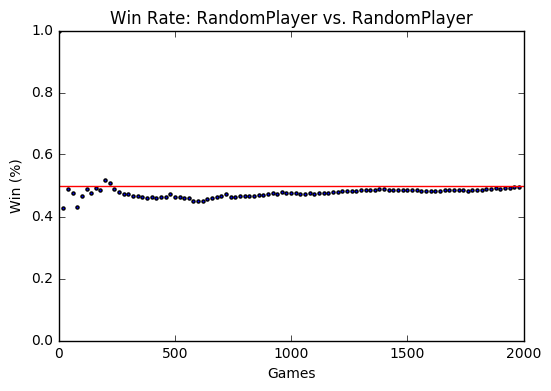

In [13]:
# Random vs. Random
chaosIterations = 2000
start = time.time()
wins = [0, 0]
winRecordTracker = {}
p1 = players.RandomPlayer()
p2 = players.RandomPlayer()

for i in range(chaosIterations):
    g = game.Game()
    g.play(p1, p2)
    wins[g.score.index(max(g.score))] += 1
    winRecordTracker[i] = wins[0] / (i + 1)

print("Random vs. Random: {} wins to {} wins ({} games total).".format(wins[0], wins[1], chaosIterations))
print("Took", time.time() - start, "seconds.")
graph_win_percentage(winRecordTracker, "Win Rate: RandomPlayer vs. RandomPlayer")

#### Observations

We can see that win percentages remain roughly around 50%, which was expected when two players simply choosing random moves go against each other. This indicates that we were correct in assuming that there aren't any outside factors that impact the result.

## Experiments

### Helper Functions

To make it easier to perform our experiments, we made several helper functions that we could reuse across multiple tests. The first 2 are functions that allow us to easily train and test an AIPlayer against a RandomPlayer.

In [14]:
def trainVsRandom(aiPlayer, randPlayer, iterations, epsilonDecay):
    # Initialize Variables
    start = time.time()
    aiWins = 0
    winPercent = {}
    # Configure AIPlayer
    aiPlayer.train = True
    for i in range(iterations):
        g = game.Game()
        if i % 2 is 0:
            g.play(aiPlayer, randPlayer)
        else:
            g.play(randPlayer, aiPlayer)
        if g.score.index(max(g.score)) is aiPlayer.playernum:
            aiWins += 1
        winPercent[i] = aiWins / (i + 1)
        aiPlayer.epsilon *= epsilonDecay
    print("Training AIPlayer vs. RandomPlayer")
    print("Final Score:\tAI: {} wins.\tRandom: {} wins.".format(aiWins, iterations - aiWins))
    print("Completed in {} seconds.\n".format(time.time() - start))
    return winPercent

def testVsRandom(aiPlayer, randPlayer, iterations):
    # Initialize Variables
    start = time.time()
    aiWins = 0
    winPercent = {}
    # Configure AIPlayer
    aiPlayer.train = False
    for i in range(iterations):
        g = game.Game()
        if i % 2 is 0:
            g.play(aiPlayer, randPlayer)
        else:
            g.play(aiPlayer, randPlayer)
        if g.score.index(max(g.score)) is aiPlayer.playernum:
            aiWins += 1
        winPercent[i] = aiWins / (i + 1)
    print("Testing AIPlayer vs. RandomPlayer")
    print("Final Score:\tAI: {} wins.\tRandom: {} wins.".format(aiWins, iterations - aiWins))
    print("Completed in {} seconds.\n".format(time.time() - start))
    return winPercent

The last 2 functions allow us to easily train and test AIPlayers against each other.

In [18]:
def trainVsAi(ai1, ai2, iterations, epsilonDecay):
    # Initialize Variables
    start = time.time()
    ai1Wins = 0
    winPercent = {}
    # Configure AIPlayers
    ai1.train = True
    ai2.train = True
    for i in range(iterations):
        g = game.Game()
        if i % 2 is 0:
            g.play(ai1, ai2)
        else:
            g.play(ai2, ai1)
        if g.score.index(max(g.score)) is ai1.playernum:
            ai1Wins += 1
        p1.epsilon *= epsilonDecay
        p2.epsilon *= epsilonDecay
        winPercent[i] = ai1Wins / (i + 1)
    print("Training AIPlayer vs. AIPlayer")
    print("Final Score:\tAI: {} wins.\tRandom: {} wins.".format(aiWins, iterations - aiWins))
    print("Completed in {} seconds.\n".format(time.time() - start))
    return winPercent

def testVsAi(ai1, ai2, iterations):
    start = time.time()
    ai1.train = False
    ai2.train = False
    ai1Wins = 0
    winPercent = {}
    for i in range(iterations):
        g = game.Game()
        if i % 2 is 0:
            g.play(ai1, ai2)
        else:
            g.play(ai2, ai1)
        if g.score.index(max(g.score)) is ai1.playernum:
            ai1Wins += 1
        winPercent[i] = ai1Wins / (i + 1)
    print("Testing AIPlayer vs. AIPlayer")
    print("Final Score:\tAI: {} wins.\tRandom: {} wins.".format(aiWins, iterations - aiWins))
    print("Completed in {} seconds.\n".format(time.time() - start))
    return winPercent

### Experiment 1: Learning from Chaos

Our first test is to simply train an AIPlayer against a RandomPlayer over 2,000 iterations, and then see how well that AIPlayer performs against the same opponent after training.

In [15]:
trainIterations = 2000
testIterations = 200
rho = 0.2
initialEpsilon = 1.0
epsilonDecay = 0.99

p1 = players.AIPlayer(rho=rho, epsilon=initialEpsilon)
p2 = players.RandomPlayer()

Training AIPlayer vs. RandomPlayer
Final Score:	AI: 1964 wins.	Random: 36 wins.
Completed in 8.42428207397461 seconds.

Final Win Rate:  0.982


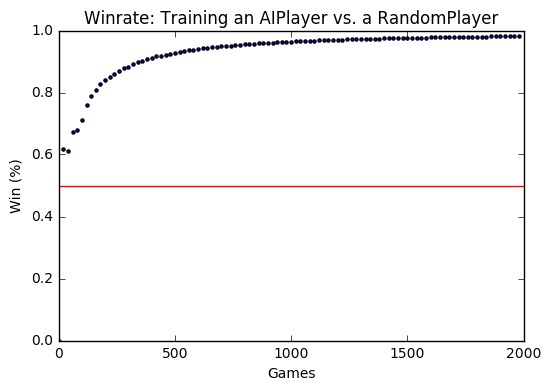

In [16]:
winrateTrain = trainVsRandom(p1, p2, trainIterations, epsilonDecay)
graph_win_percentage(winrateTrain, "Win Rate: Training an AIPlayer vs. a RandomPlayer")

Testing AIPlayer vs. RandomPlayer
Final Score:	AI: 199 wins.	Random: 1 wins.
Completed in 0.7962324619293213 seconds.

Final Win Rate:  0.995


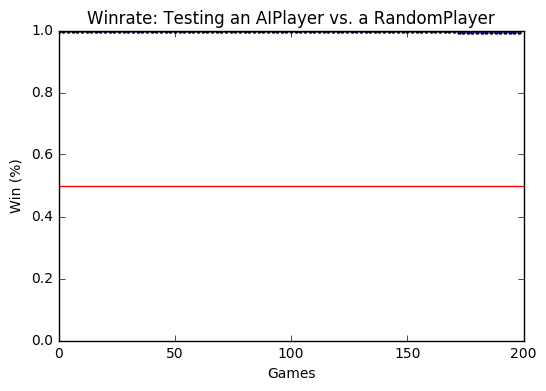

In [17]:
p1.epsilon = 0.01
winrateTest = testVsRandom(p1, p2, testIterations)
graph_win_percentage(winrateTest, "Win Rate: Testing an AIPlayer vs. a RandomPlayer")

#### Obserations

The data clearly shows that using reinforcement versus a random player will result in consistent wins. Does it though? It does now that epsilon decay is being applied. Oops...

### Experiment 2: The Same Thing, but More

We decided to increase the number of training games played between the AIPlayer and the RandomPlayer to see if that had any impact on the final win rate, the concern being that we would see adverse affects from overtraining. Training iteration counts were multiplied by 10 compared to experiment 1. Nothing else was changed, aside from random number generator seeds.

In [19]:
trainIterations = 20000
testIterations = 200
rho = 0.2
initialEpsilon = 1.0
epsilonDecay = 0.99

p1 = players.AIPlayer(rho=rho, epsilon=initialEpsilon)
p2 = players.RandomPlayer()

Training AIPlayer vs. RandomPlayer
Final Score:	AI: 19927 wins.	Random: 73 wins.
Completed in 88.316725730896 seconds.

Final Win Rate:  0.99635


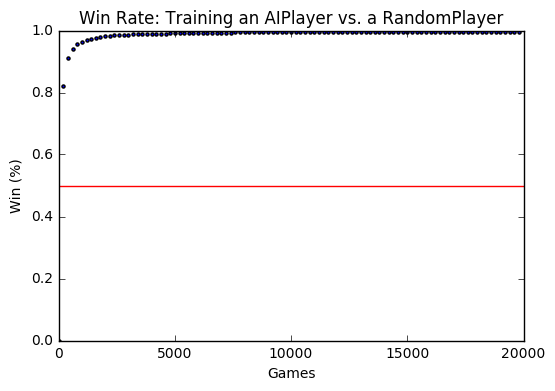

In [20]:
winrateTrain = trainVsRandom(p1, p2, trainIterations, epsilonDecay)
graph_win_percentage(winrateTrain, "Win Rate: Training an AIPlayer vs. a RandomPlayer")

Testing AIPlayer vs. RandomPlayer
Final Score:	AI: 200 wins.	Random: 0 wins.
Completed in 0.8170428276062012 seconds.

Final Win Rate:  1.0


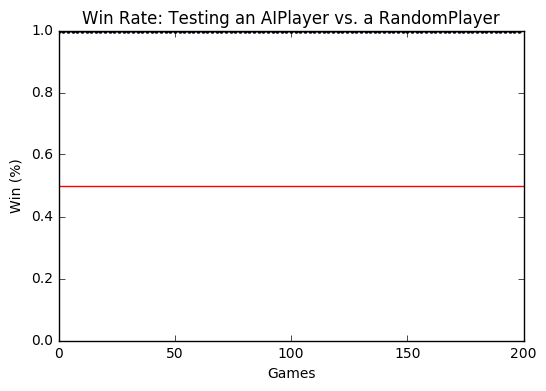

In [21]:
winrateTest = testVsRandom(p1, p2, testIterations)
graph_win_percentage(winrateTest, "Win Rate: Testing an AIPlayer vs. a RandomPlayer")

#### Observations

Here, we noticed that, in this case, training over 20,000 iterations did not give us any adverse affects related to overtraining. However, since we already started at a win rate of 99.5%, going up to 100% is not a significant change.

### Experiment 3: Making Things Worse

Now that we've proven we can reliably beat a RandomPlayer, it's time to figure out what it takes to negatively impact the win rate. Here, we've increased the number of testing iterations to 1,000, while dropping the number of training iterations to attempt to negatively impact the win rate. Our objective was to see what it took to get the win rate down to 80%, our original target.

In [86]:
trainIterations = 75
testIterations = 1000
rho = 0.2
initialEpsilon = 1.0
epsilonDecay = 0.99

p1 = players.AIPlayer(rho=rho, epsilon=initialEpsilon)
p2 = players.RandomPlayer()

Training AIPlayer vs. RandomPlayer
Final Score:	AI: 46 wins.	Random: 29 wins.
Completed in 0.38425421714782715 seconds.

Final Win Rate:  0.6133333333333333


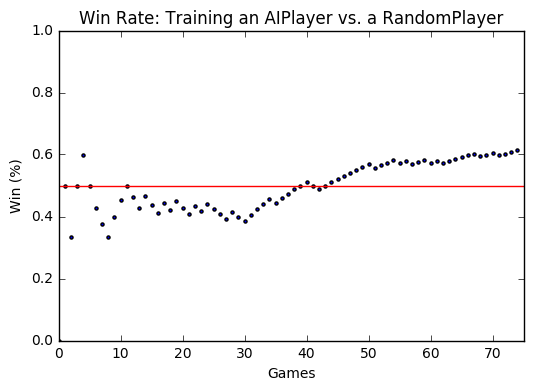

In [87]:
winrateTrain = trainVsRandom(p1, p2, trainIterations, epsilonDecay)
graph_win_percentage(winrateTrain, "Win Rate: Training an AIPlayer vs. a RandomPlayer")

Testing AIPlayer vs. RandomPlayer
Final Score:	AI: 803 wins.	Random: 197 wins.
Completed in 4.5437304973602295 seconds.

Final Win Rate:  0.803


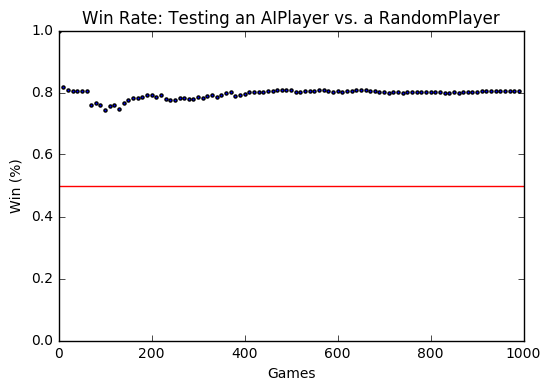

In [88]:
winrateTest = testVsRandom(p1, p2, testIterations)
graph_win_percentage(winrateTest, "Win Rate: Testing an AIPlayer vs. a RandomPlayer")

#### Observations

After testing, we discovered that around 75 iterations would give us around an 80% win rate, suggesting that this game is extremely easy to learn, our RandomPlayer is extremely easy to play against, or both. 

# For Making Diagrams (REMOVE BEFORE SUBMISSION)

In [ ]:
b = game.Game.Board()

b[0, 0] = True

b[1, 0] = True
b[1, 1] = True

b[2, 0] = True

b[3, 0] = True
b[3, 1] = True

b[4, 0] = True

b[5, 0] = True
b[5, 1] = True

b[6, 0] = True
b[6, 1] = True
b[6, 2] = True

b[7, 0] = True
b[7, 1] = True
b[7, 2] = True
b[7, 3] = True

b[8, 0] = True
b[8, 1] = True
b[8, 2] = True

b[9, 0] = True
b[9, 1] = True
b[9, 2] = True
b[9, 3] = True

b[10, 0] = True
b[10, 1] = True
b[10, 2] = True

graph_board(b)

# Conclusion

The data shows ...